# Ayuda slides

In [1]:
print '''Copy the next code into a first Raw NBconvert Cell to avoid display the commands
<style type="text/css">
.input, .output_prompt {
display:none !important;
}
</style>
'''

Copy the next code into a first Raw NBconvert Cell to avoid display the commands
<style type="text/css">
.input, .output_prompt {
display:none !important;
}
</style>



'b' to hide presentation

Links:
* http://stackoverflow.com/questions/20441848/how-do-i-separate-slides-when-exporting-an-ipython-notebook-to-reveal-js    
* http://www.slideviper.oquanta.info/tutorial/slideshow_tutorial_slides.html#/7  
* https://seqqc.wordpress.com/2015/02/22/make-slides-with-ipython-notebook/
* http://hannes-brt.github.io/blog/2013/08/11/ipython-slideshows-will-change-the-way-you-work/

The commands in the final Cell gives the separation of slides and arrows:

In [2]:
%%bash
ipython nbconvert Indicadores-articulos.ipynb --to slides --reveal-prefix "http://cdn.jsdelivr.net/reveal.js/2.6.2" && cp Indicadores-articulos.slides.html /var/www/downloads
#git commit -am "Slides update"
#git push origin master

[NbConvertApp] Converting notebook Indicadores-articulos.ipynb to slides
[NbConvertApp] Writing 392030 bytes to Indicadores-articulos.slides.html
cp: cannot create regular file ‘/var/www/downloads’: Permission denied


The resulting slides are here:

http://gfif.udea.edu.co/downloads/Indicadores-articulos.slides.html#/

or

* http://htmlpreview.github.io/?https://github.com/restrepo/gssis/blob/master/pandas/Indicadores-articulos.slides.html#/
* http://htmlpreview.github.io/?https://github.com/restrepo/gssis/blob/master/pandas/Indicadores-articulos-simple.slides.html#/

<h1>Indicadores Instituto de Física</h1>
<h3>Diego Restrepo</h3>


<h3>Adevertencia:</h3>
El análisis de datos se ha realizado con procesos automáticos propensos a errores de programación.

http://stackoverflow.com/a/17231361

<h2 id="Articulos">Artículos</h2>
###Metodologia
Desde el perfil de [Google Scholar](https://scholar.google.com/citations?sortby=pubdate&hl=en&user=mxSOjTYAAAAJ&view_op=list_works) para el Instituto, se exportan todos los artículos en formato cvs.

Con el programa `cvsreader_udea.py` en la carpeta `utilities` del repositorio  de GitHub [`gssis`](https://github.com/restrepo/gssis) se añade la siguiente información:  

* El [DOI](http://search.crossref.org), usando el título y el apellido del primer autor de la publicación

* Con del DOI se pueden verificar todos los metadatos. En particular el nombre exacto de la revista. [Ejemplo](http://api.crossref.org/works/10.1103/PhysRevD.93.015012) 

* Con el nombre exacto de la revista se obtiene la clasificación de Colciencias y su ISSN asociado desde la versión en [google spreadsheet](https://docs.google.com/spreadsheets/d/1umgapW8KOIPqmu_hyjon3n2SXbnbDlmnRnXzjUHcXHE/edit?usp=drive_web) del arhivo en excel del Publindex de Colciencias para revistas homologadas. (Se carga el csv desde el código)

* Con el ISSN se obtiene el factor de impacto con: [búsqueda de Google](https://goo.gl/JMHmhS)

* [La página web con el perfil de Google Scholar](https://scholar.google.com/citations?sortby=pubdate&hl=en&user=mxSOjTYAAAAJ&view_op=list_works) muestra hasta 1000 entradas en una tabla de tres columas con la información del artículo, el número de citas y el año de publicación. Si la correspondiente tabla se copia directamente en una hoja cálculo de Google, luego puede ser cargada como un archivo `csv` desde `pandas`. El título del artículo en la base de datos enriquecida de artículos puede ser contrastada con la columna de información de la hoja de cáculo de citaciones para asignarle el número de citas correspondiente. De ser necesario se puede recurrir a otra información de artículo como el por ejemplo: el volumen de la revista en que fue publicado

Finalmente el programa extrae el primer autor de la UdeA de la lista de autores y le asocia el Grupo de Investigación correspondiente.

El resultado final esta en el [repositorio de GitHub](https://github.com/restrepo/gssis/blob/master/utilities/newcitations.csv)

##  Preparación de datos

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 15})
#identificadores de Grupo:
s={'GFIF':'g-','GES':'r:','GMC':'c--','GOF':'m-.','MS':'y-','GFAM':'k:','FACOM':'b-'}

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import numpy as np
import datetime
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth',500)
def read_google_cvs(gss_url="http://spreadsheets.google.com",\
    gss_format="csv",\
    gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",\
    gss_sheet=0,\
    gss_query="select B,D,E,F,I where (H contains 'GFIF') order by D desc",\
    gss_keep_default_na=False
    ):
    import urllib
    """
    read a google spreadsheet in cvs format and return a pandas DataFrame object.
       ....
       gss_keep_default_na: (False) Blank values are filled with NaN
    """
    issn_url="%s/tq?tqx=out:%s&tq=%s&key=%s&gid=%s" %(gss_url,\
                                           gss_format,\
                                           gss_query,\
                                           gss_key,\
                                           str(gss_sheet))

    gfile=urllib.urlopen(issn_url)
    return pd.read_csv(gfile,keep_default_na=gss_keep_default_na)

def plainstr(stra):
    return stra.replace('á','a').replace('é','e').replace('í','i').\
                replace('ó','o').replace('ú','u').replace('ñ','n')

### Cargue base de datos de artículos
Desde el [repositorio de GitHub](https://github.com/restrepo/gssis/blob/master/utilities/newcitations.csv)

In [5]:
df=pd.read_csv('https://raw.githubusercontent.com/restrepo/gssis/master/utilities/newcitations.csv')
df.columns

Index([u'Year', u'Type', u'Authors', u'Publication', u'Volume', u'Pages',
       u'ISSN', u'Title', u'Impreso', u'PDF', u'Group', u'DOI', u'Type II',
       u'Proyect ID', u'Institution Authors', u'Colciencias Clasification',
       u'Impact Factor', u'Proyecto', u'NPages'],
      dtype='object')

### Arregle manualmente
Artículos con muchos autores

In [6]:
df.Group=df.Group.fillna('Unknown')
jdr=df[df.Group=='Unknown']
jdri=jdr[np.logical_or(jdr.ISSN=='1126-6708',jdr.ISSN=='1550-7998')].index
for i in jdri:
    df.Group[i]='GFIF: Grupo de Fenomenología de Interacciones Fundamentales'
    df['Institution Authors'][i]='José David Ruíz Álvarez'

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
i=df[df.Publication.str.lower().str.contains('nature')].index[0]
df.Group[i]='GFAM: Grupo de Física Atómica y Molecular'
df['Institution Authors'][i]='Sanz Vicario José Luis'
df['Impact Factor'][i]='41,456'

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


###Compatibilidad con la carpeta de Indicadores de Google Spread Sheet

In [8]:
df['Año']=df.Year
df['Tipo']=df.Type
df['Autor(es)']=df.Authors
df['Artículo']=df.Title
df['Vol.']=df.Volume
df['pág.']=df.Pages
df['Revista']=df.Publication
df['Grupo']=df.Group
df['Clasificación Colciencias']=df['Colciencias Clasification']
df['Factor de Impacto']=df['Impact Factor']

### Primer autor UdeA

In [9]:
df['First_UdeA_Author']=df['Institution Authors'].fillna('NN')\
.str.replace('Mora Ramos Miguel; ','').str.replace(';.*','')

### Área

In [10]:
df['Area']='Desconocida'
for G in ['GMC','FACOM','GFAM','MS','GFIF','FN']:
    for i in df[df.Grupo.str.contains(G)].index:
        df.Area[i]='Teórica'

for G in ['GICM','GES','GOF','Biofísica','FIR']:
    for i in df[df.Grupo.str.contains(G)].index:
        df.Area[i]='Experimental'
        
#manual fix
for TGES in ['Morales Aramburo Álvaro','Osorio Guillén Jorge Mario','Reyes Gómez Ernesto Amador']:
    for i in df[df.First_UdeA_Author.str.contains(TGES)].index:
        df.Area[i]='Teórica'        

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Incluyendo citaciones...

To include in official code cvsreader_udea.py

In [11]:
pc=read_google_cvs(gss_key='1yQXdQdzsX9zBeui52bMcnN-JMt87ofHDjA58kwGJsdI',gss_query="select *")

In [12]:
df['Cites']=0
df['Simple']=df.Title.str.replace(r"[^a-zA-Z0-9 ]", " ").str.lower().str.replace('\s+','')
pc['Simple']=pc.Article.str.replace(r"[^a-zA-Z0-9 ]", " ").str.lower().str.replace('\s+','')
for i in range(df.shape[0]):
    mt=pc[pc.Simple.str.match(df.Simple[i])]
    if len(mt)>0:
        if len(mt)>1: #multiple matches. Refine search with, e.g, volume
            mtv=mt[mt.Simple.str.contains(str(df.Volume[i]))]
            if len(mtv)>0:
                mt=mtv
        
        df['Cites'][i]=mt.Cites.replace('*','').replace('','0').astype(int).max()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Expected 12994 (Feb. 2016)

In [13]:
df.Cites.sum()

12642

### Filtramos las publicadas
Las que tienen ISSN o el DOI.

Se muestran algunos resultados...

In [14]:
publicadas=df[~np.logical_and(df['ISSN']=='0000-0000',df['DOI']=='Not DOI')]
publicadas=publicadas.reset_index(drop=True)
publicadas=publicadas.replace('','Desconocido')
#publicadas['First_UdeA_Author']=publicadas['Institution Authors'].fillna('NN')\
#.str.replace('Mora Ramos Miguel; ','').str.replace(';.*','')

#Ejemplo visualización
publicadas[['Año','Autor(es)','Artículo','Vol.','pág.','ISSN','Revista','Grupo','DOI','Clasificación Colciencias','Factor de Impacto','First_UdeA_Author']][publicadas['DOI']!='Not DOI'][-5:]

,Año,Autor(es),Artículo,Vol.,pág.,ISSN,Revista,Grupo,DOI,Clasificación Colciencias,Factor de Impacto,First_UdeA_Author
953,2015,"Hollyhead, Katherine; Bastian, Nate; Adamo, Angela; Silva-Villa, Esteban; Dale, Jim; Ryon, JE; Gazak, Zack;","Studying the YMC population of M83: how long clusters remain embedded, their interaction with the ISM and implications for GC formation theories",449,1106,0035-8711,Monthly Notices of the Royal Astronomical Society,FACOM: Física y Astrofísica Computacional,10.1093/mnras/stv331,A1,"5,521",Silva Villa Esteban
954,2014,"Ceballos, Jorge A; Giraldo, Marco A; Cossio, Pilar;",Effects of a disulfide bridge prior to amyloid formation of the ABRI peptide,4,36923,0000-0000,RSC Advances,Biofísica,10.1039/C4RA06034B,00,"-1,0",Giraldo Cadavid Marco A.
955,2014,"Bastian, N; Adamo, Angela; Schirmer, M; Hollyhead, K; Beletsky, Y; Carraro, G; Davies, B; Gieles, M; Silva-Villa, E;",The effect of spatial resolution on optical and near-IR studies of stellar clusters: implications for the origin of the red excess,444,3829,0035-8711,Monthly Notices of the Royal Astronomical Society,FACOM: Física y Astrofísica Computacional,10.1093/mnras/stu1695,A1,"5,521",Silva Villa Esteban
956,2015,"Salazar, Camilo; Benavides, Richard H; Ponce, William A; Rojas, Eduardo;",LHC constraints on 3-3-1 models,2015,1,1126-6708,Journal of High Energy Physics,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,10.1007/JHEP07(2015)096,A1,"5,618",Ponce Gutiérrez William Alberto
957,2015,"Benavides, Richard H; Epele, Luis N; Fanchiotti, Huner; García Canal, Carlos; Ponce, William A;",Lepton number violation and neutrino masses in 3-3-1 models,2015,1,1687-7357,Advances in High Energy Physics,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,10.1155/2015/813129,A2,"2,203",Ponce Gutiérrez William Alberto


In [15]:
publicadas['Factor de Impacto']=publicadas['Factor de Impacto'].replace('Desconocido',-1)
publicadas['Factor de Impacto']=publicadas['Factor de Impacto'].str.replace(',','.').astype(float)
publicadas['Grupo']=publicadas['Grupo'].fillna('Unknown')

### Publicadas últimos 5 años

Desde 2011

In [16]:
datetime.datetime.now().year-5

2011

In [17]:
publicadas5=publicadas[publicadas['Año']>datetime.datetime.now().year-6]

### Datos a analizar del TOTAL en Google Scholar:

In [18]:
dfp=pd.DataFrame()
dfp.append({'TOTAL':df.shape[0],'Publicadas':publicadas.shape[0],\
            'Publicadas últimos 5 años':publicadas5.shape[0]},ignore_index=True)

,Publicadas,Publicadas últimos 5 años,TOTAL
0,958,337,1007


## Preparando la tabla de datos principal
Similar a la [compartida por correo](https://goo.gl/z9nley) que fue obtenida con conteo manual de artículos.

### Estudiantes

In [19]:
config_inf={'DEBUG':False} #Development mode
config_inf['Years']=range(1995,2016)

In [20]:
dfd=read_google_cvs(gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",gss_query="select *",gss_sheet=2)
dfd['PROGRAMA']='Doctorado'
dfm=read_google_cvs(gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",gss_query="select *",gss_sheet=1)
dfm['PROGRAMA']='Maestría'
dfe=dfd.append(dfm)

Convertir YYYY-S a YYYY, e.g 2015-1 a 2015

In [21]:
dfe['Año de ingreso']=dfe['Fecha de ingreso'].replace('','0').replace('null','0').str.replace('-1','').str.replace('-2','').astype('int')
dfe['Año de graduación']=dfe['Fecha de graduación'].replace('','0').replace('null','0').str.replace('-1','').str.replace('-2','').astype('int')#.values
dfe['Año de graduación'].values
dfei=dfe[dfe['Año de ingreso']>=config_inf['Years'][0]].reset_index(drop=True)
dfeg=dfe[dfe['Año de graduación']>=config_inf['Years'][0]].reset_index(drop=True)

##### Estudiantes  matriculados

In [22]:
dfeit=dfei[np.logical_or(dfei['Estado']=='Activo',dfei['Estado']=='Graduado')]
dfeit[['Año de ingreso','Estado']]
nuevos=dfei.groupby('Año de ingreso').count()['ASESOR'][::-1]

##### Artículos con participación de estudiantes

In [23]:
dfei=dfei[dfei.Estado!='Desertor'].reset_index(drop=True)
#Estudiantes
student_coauthor=1 #until 2 years after graduation date
dfd=pd.Series()
art_est=pd.Series()
dfd['D']=dfei[dfei.PROGRAMA=='Doctorado'].reset_index(drop=True)
dfd['M']=dfei[dfei.PROGRAMA=='Maestría'].reset_index(drop=True)
dfd['P']=dfei
for k in dfd.keys():
    art_est[k]=pd.DataFrame()
    if k=='P': est_p=pd.DataFrame()
#phdest=pd.DataFrame()
    dfd[k]['Author']=''
    for i in range(dfd[k].shape[0]):
        est=re.sub('\s+$','',re.sub('^\s+','',dfd[k]['ESTUDIANTE'][i])).replace('  ',' ').split(' ')
        if len(est)==4:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[2]),est[0][0])
        elif len(est)==3:        
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[1]),est[0][0])
        elif len(est)==2:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[1]),est[0][0])
        else:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[-1]),est[0][0])
        #special cases
        if dfd[k]['Author'][i]=='Duque, C':
            dfd[k]['Author'][i]='Duque, CM'
        if dfd[k]['Author'][i]=='Restrepo, J':
            dfd[k]['Author'][i]='Restrepo Cuartas, J'
    
        ma=publicadas[publicadas['Autor(es)'].str.contains(dfd[k]['Author'][i])]
        if ma.shape[0]>0: #Check also Group
            ma['Estudiante']=dfd[k]['Author'][i]
            ma['Estudiante_full']=dfd[k]['ESTUDIANTE'][i]
            ma['Año Graduación']=dfd[k]['Año de graduación'][i]
            ma=ma[ma['Año']>=dfd[k]['Año de ingreso'][i]]
            if dfd[k]['Fecha de graduación'][i]!='':
                ya=dfd[k]['Año de graduación'][i]+student_coauthor
                #ya=eval(re.sub('-[12]$','',dfd[k]['Fecha de graduación'][i]))+student_coauthor
                ma=ma[ma['Año']<=ya]
    
        art_est[k]=art_est[k].append(ma)

    if k=='P':est_p=art_est[k].drop_duplicates()    
    art_est[k]=art_est[k].drop_duplicates().reset_index(True).sort('Año',ascending=False).reset_index(drop=True)
    art_est[k]=art_est[k][['Tipo','Artículo','Autor(es)','Año Graduación','Año','Revista','ISSN','Estudiante']]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Todo: 'Año Graduación' :USAR PARA FILTRAR Profesores cuando eran estudiantes

In [24]:
#est_p.sort('Año Graduación',ascending=False)['Año Graduación'][i]

In [25]:
publicadas['Estudiantes']=''
publicadas['Año Graduación']=0 
for i in est_p.index:
    lst=sorted(np.unique(est_p['Estudiante_full'][i]))
    sep=''
    if len(lst)>1: sep='; '
    lst=sep.join(lst)
    lst=lst.replace('John Jairo Zuluaga Quintero; Jorge Ivan Zuluaga Callejas','Jorge Ivan Zuluaga Callejas')
    lst=lst.replace('Johan Mazo-Zuluaga; Jorge Ivan Zuluaga Callejas','Jorge Ivan Zuluaga Callejas')
    lst=lst.replace('Johan Mazo-Zuluaga; Juan Pablo Restrepo Cuartas','Johan Mazo-Zuluaga')
    publicadas['Estudiantes'][i]=lst
    #publicadas['Año Graduación'][i]=est_p.sort('Año Graduación',ascending=False\
    #                                          )['Año Graduación'][i].reset_index(drop=True)[:-1][0]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Contar artículos por año
y clasisificarlos

In [26]:
G=pd.Series()
grupos=['GFIF','GES','GFAM','GMC','GOF','MS','FACOM']
t=publicadas['Año'].value_counts()
i=publicadas[publicadas.Tipo=='Internacional']['Año'].value_counts()
n=publicadas[publicadas.Tipo=='Nacional']['Año'].value_counts()
facom=publicadas[publicadas.Grupo.str.contains('FACOM')]['Año'].value_counts()
for g in grupos:
    G[g]=publicadas[publicadas.Grupo.str.contains(g)]['Año'].value_counts()

In [27]:
autor=pd.Series()
autor['Posgrado']=art_est.P.groupby('Año').count().Tipo[::-1]
autor['Doctorado']  =art_est.D.groupby('Año').count().Tipo[::-1]
autor['Master']=art_est.M.groupby('Año').count().Tipo[::-1]

## Datos consolidados
Prepare pandas DataFrame

In [28]:
rdf=pd.DataFrame()
ng=pd.Series()
for y in range(1995,2016)[::-1]:
    year=False
    if y in t.keys():
        na=t[y]
    else: na=0
    if y in i.keys():
        ni=i[y]
    else: ni=0
    if y in n.keys():
        nn=n[y]
    else: nn=0
    if y in facom.keys():
        nfacom=facom[y]
    else: nfacom=0
    for g in grupos:
        if y in G[g].keys():
            ng[g]=G[g][y]
    else: nges=0
    for k in ['Posgrado','Master','Doctorado']:
        if not y in autor[k]:
            autor[k][y]=0
    #FAudea=publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN')\
    #.str.replace('Mora Ramos Miguel; ','').str.replace(';.*','').unique().shape[0]
    FAudea=publicadas[publicadas['Año']==y]['First_UdeA_Author'].unique().shape[0]
    Audea=np.unique(publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
    pes=publicadas[publicadas['Año']==y]
    Eudea=np.unique(pes[pes['Estudiantes']!='']['Estudiantes'].str.split('; ').sum())
    if Eudea==np.array([0]): #simplify code
        Eudea=0
    else:
        Eudea=Eudea.shape[0]
        #'GES','GOF','GFIF'
    rdf=rdf.append({'year':y,'articles':na,'isi_o_scopus':ni,'nacional':nn,'facom':nfacom,\
                   'GFIF':ng['GFIF'],'GES':ng['GES'],'GFAM':ng['GFAM'],'GMC':ng['GMC'],\
                    'GOF':ng['GOF'],'MS':ng['MS'],'FACOM':ng['FACOM'],\
                    'first_UdeA_author':FAudea,'UdeA_author':Audea,\
                   'art_posgrado':autor.Posgrado[y],'art_master':autor.Master[y],\
                    'art_doctorado':autor.Doctorado[y],'UdeA_estudiante':Eudea},ignore_index=True)

rdf

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,FACOM,GES,GFAM,GFIF,GMC,GOF,MS,UdeA_author,UdeA_estudiante,art_doctorado,art_master,art_posgrado,articles,facom,first_UdeA_author,isi_o_scopus,nacional,year
0,4,18,7,7,26,7,2,21,10,16,3,18,66,4,20,62,4,2015
1,6,11,11,7,25,4,5,22,11,10,4,14,70,6,21,65,5,2014
2,4,20,7,12,14,6,4,27,8,9,5,14,70,4,24,62,8,2013
3,1,9,7,8,26,5,6,17,6,7,4,11,62,1,16,59,3,2012
4,1,16,8,6,20,6,5,22,6,4,6,10,65,1,21,59,6,2011
5,1,16,8,3,12,5,5,21,12,9,8,17,56,1,19,50,6,2010
6,2,15,23,13,18,12,7,26,13,16,10,26,95,2,22,70,25,2009
7,2,28,7,6,15,2,2,22,14,12,13,25,60,2,19,55,5,2008
8,2,15,2,4,20,3,8,16,10,12,10,22,49,0,15,39,10,2007
9,1,27,5,10,13,9,9,27,13,24,7,31,71,1,24,49,22,2006


# Resultados

## Resultados sobre número de publicaciones

En el plano: número de artículos en función del año. Se añade la información de cuantos primeros autores de la UdeA participan en los artículos

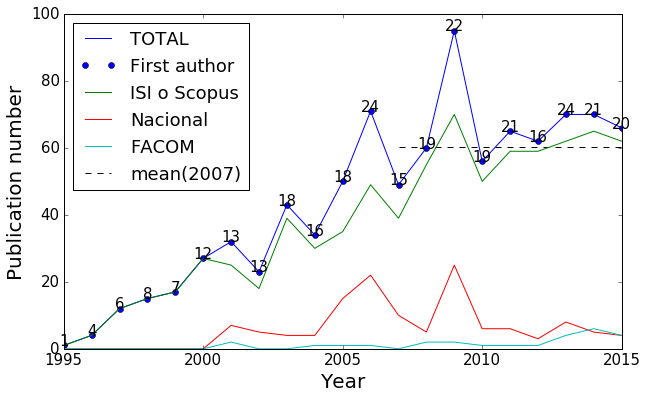

In [29]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.articles,'bo',label='First author')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.facom,label=u'FACOM')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.first_UdeA_author[i])),xy=(rdf.year[i],rdf.articles[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)

En los picos hay una mezcla de profesores y estudiantes...

O en términos del número de autores total de la UdeA que participan en los artículos

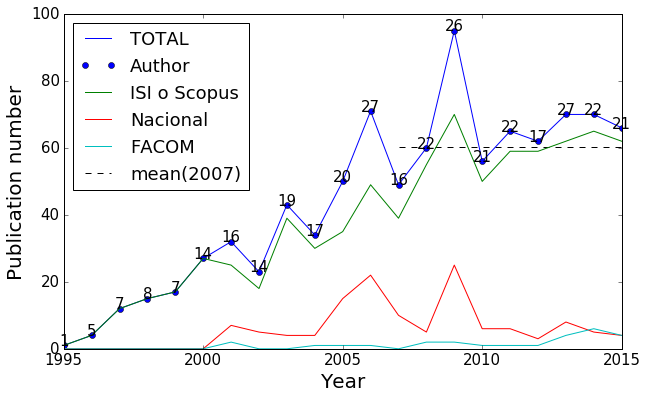

In [30]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.articles,'bo',label='Author')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.facom,label=u'FACOM')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.UdeA_author[i])),xy=(rdf.year[i],rdf.articles[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)

2009 Team

In [31]:
y=2009
values=np.unique(publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN').str.split('; ').sum())
pd.Series(dict(zip(range(values.shape[0]), values)))

0                Arnache Olmos Óscar L.
1            Barrera Ramírez John Fredy
2              Barrero Meneses César A.
3                Carlos Duque Echeverri
4                          Girata Doris
5                   Henao Henao Rodrigo
6            Jaramillo Arango Daniel E.
7                Mahecha Gómez Jorge E.
8                    Mazo Zuluaga Johan
9                Mira Agudelo Alejandro
10              Morales Aramburo Álvaro
11                                   NN
12                         Nardi Enrico
13           Osorio Guillén Jorge Mario
14                   Osorio Vélez Jaime
15      Ponce Gutiérrez William Alberto
16                          Páez Manuel
17             Restrepo Cárdenas Johans
18    Restrepo Quintero Diego Alejandro
19           Reyes Gómez Ernesto Amador
20          Rodríguez Rey Boris Anghelo
21                  Romano Antonio Enea
22            Rueda Muñoz Edgar Alberto
23               Sanz Vicario José Luis
24                  Zapata Noreña Oscar


O en términos del número de estudiantes de posgrado en la lista de autores 

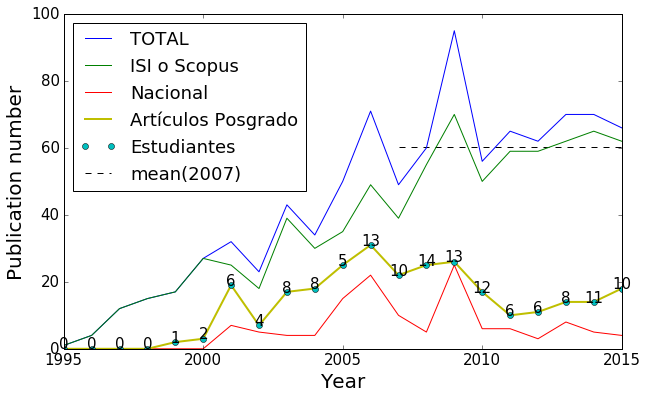

In [32]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.art_posgrado,'y-',lw=2,label=u'Artículos Posgrado')
plt.plot(rdf.year,rdf.art_posgrado,'co',lw=2,label='Estudiantes')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.UdeA_estudiante[i])),xy=(rdf.year[i],rdf.art_posgrado[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)

2009 Student's Team

In [33]:
y=2009
values=np.unique(publicadas[np.logical_and(publicadas.Year==y,publicadas.Estudiantes!='')].Estudiantes.str.split('; ').sum())
pd.Series(dict(zip(range(values.shape[0]), values)))

0         Beatriz Elena Londoño Flórez
1          Carlos A. Vargas Castrillón
2              Carlos Andrés Vera Ciro
3            Edgar Alberto Rueda Muñoz
4      Francisco Eugenio López Giraldo
5            Guillermo Miranda Pedraza
6     Jeaneth Patricia Urquijo Morales
7                   Johan Mazo-Zuluaga
8     Johana Alexandra Herrera Ruales 
9          Oscar Alberto Zapata Noreña
10        Ricardo León Restrepo Arango
11       Richard H. Benavides Palacios
12              Yithsbey Giraldo Usuga
dtype: object

####Observación
En los picos se nota un incremento en la participación de estudiantes, sobre todo en revistas nacionales (¿Congresos?)

Miremos entonces los Grupos

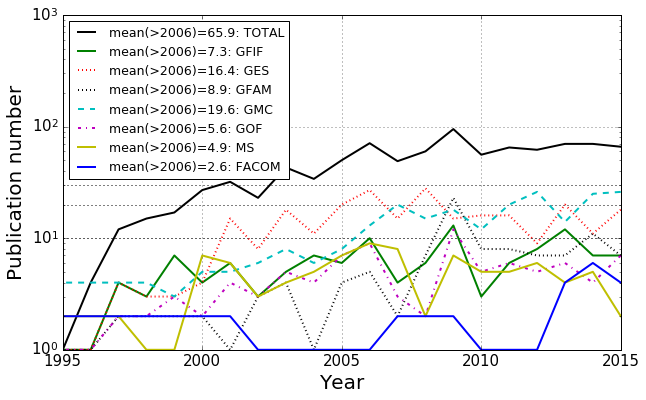

In [34]:
plt.plot(rdf.year,rdf.articles,'k-',lw=2,label='mean(>2006)=%.1F: TOTAL'  %rdf[rdf.year>2006].articles.mean(), )
#plt.plot(rdf.year,rdf.articles,'bo')
GT=np.zeros(21)

for g in grupos:
    GT=GT+rdf[g]
    plt.semilogy(rdf.year,rdf[g],s[g],lw=2,label=u'mean(>2006)=%.1F: %s'  %( rdf[rdf.year>2006][g].mean(),g ) )    
    #plt.semilogy(rdf.year,rdf[g],'k.',lw=2)    
    
#plt.semilogy(rdf.year,GT ,label='Suma')    #crosscheck
plt.hlines(10,1995,2015,linestyles=':')
plt.hlines(20,1995,2015,linestyles=':')
plt.hlines(30,1995,2015,linestyles=':')
plt.ylim(1,1000)
plt.legend(loc='upper left',fontsize='small')
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)
plt.grid()

In [35]:
'%.1F' %rdf[rdf.year>2006][g].mean()

'2.6'

## Resultados Por Grupos de Investigación

#### Histórico

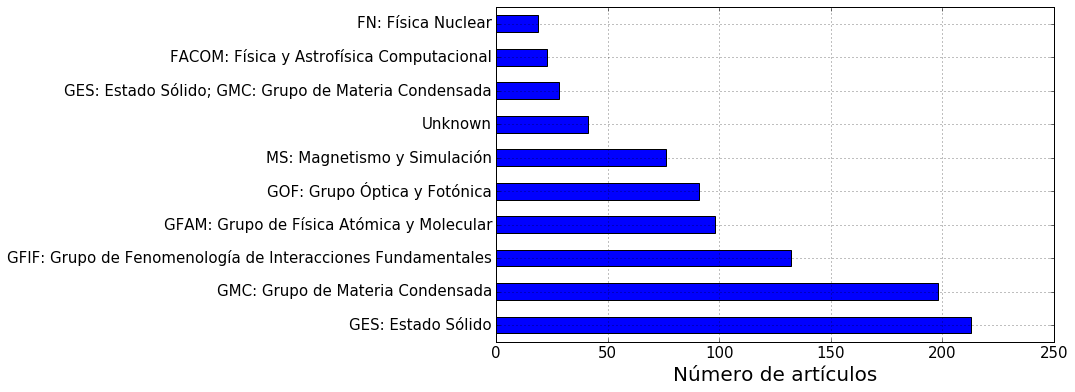

In [36]:
publicadas['Grupo'].value_counts()[:10].plot(kind='barh', rot=0, grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos cinco años


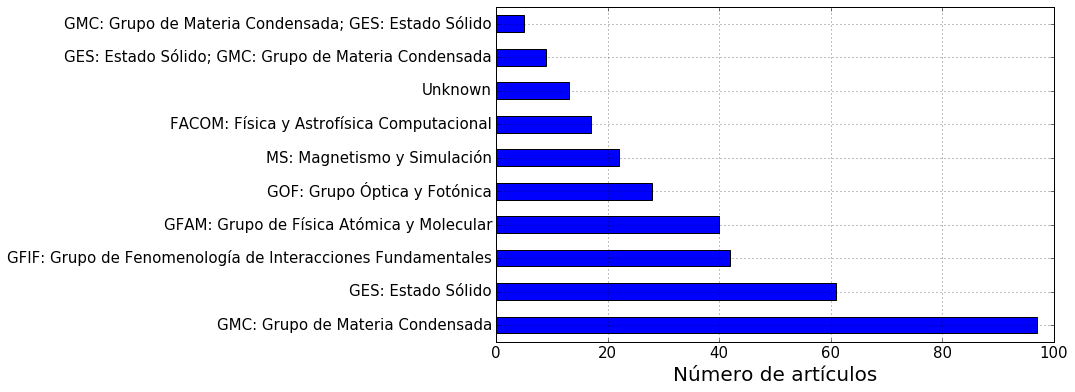

In [37]:
publicadas5['Grupo'].value_counts()[:10].plot(kind='barh', rot=0,grid=True)
plt.xlabel(u'Número de artículos',size=20)

###Conclusión
Se ha alcanzado un valor asintótico, no solo en el número total, sino también en general en los grupos

H0 lo separó en H 0 y no lo encontró: solución: admita alguna palabras faltantes en títulos largos:

* http://dx.doi.org/10.1209/0295-5075/109/39002 

## Resultados por  Áreas

####Histórico

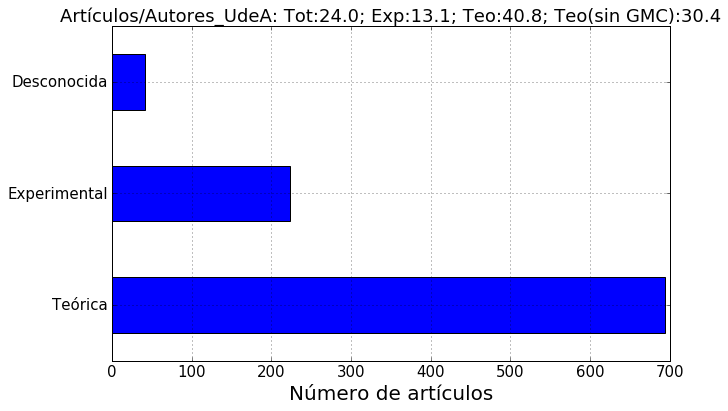

In [38]:
Tot=publicadas.shape[0]/np.unique(publicadas['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
p=publicadas['Area'].value_counts()
at=np.unique(publicadas[publicadas.Area=='Teórica']['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
ae=np.unique(publicadas[publicadas.Area=='Experimental']['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
gmc=publicadas[publicadas.Grupo.str.contains('GMC')].shape[0]
publicadas['Area'].value_counts().plot(kind='barh', rot=0, grid=True)
plt.title(u'Artículos/Autores_UdeA: Tot:%0.1f; Exp:%0.1f; Teo:%0.1f; Teo(sin GMC):%0.1f' %(Tot, p.Experimental/float(ae),p['Teórica']/float(ae),\
                                                               (p['Teórica']-gmc)/float(ae-2) ) )
plt.xlabel(u'Número de artículos',size=20)

#### Últimos 5 años:

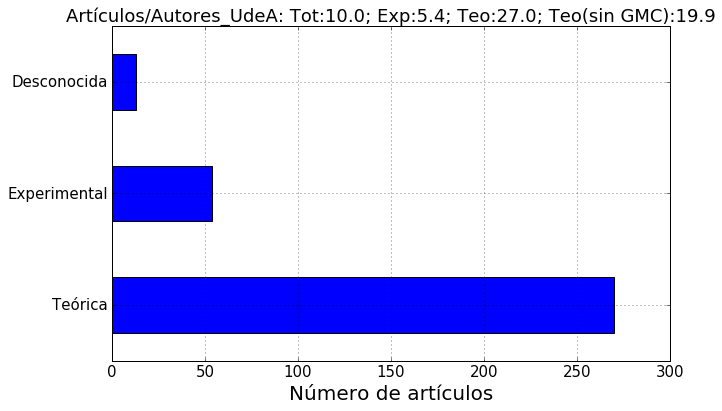

In [39]:
Tot=publicadas5.shape[0]/np.unique(publicadas5['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
p=publicadas5['Area'].value_counts()
at=np.unique(publicadas5[publicadas5.Area=='Teórica']['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
ae=np.unique(publicadas5[publicadas5.Area=='Experimental']['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
gmc=publicadas5[publicadas5.Grupo.str.contains('GMC')].shape[0]
publicadas5['Area'].value_counts().plot(kind='barh', rot=0, grid=True)
plt.title(u'Artículos/Autores_UdeA: Tot:%0.1f; Exp:%0.1f; Teo:%0.1f; Teo(sin GMC):%0.1f' %(Tot, p.Experimental/float(ae),p['Teórica']/float(ae),\
                                                               (p['Teórica']-gmc)/float(ae-2) ) )
plt.xlabel(u'Número de artículos',size=20)

#### Conclusión
En teoría se produce más

## Resultados de Primeros autores UdeA
Primeros 15

####  Histórico

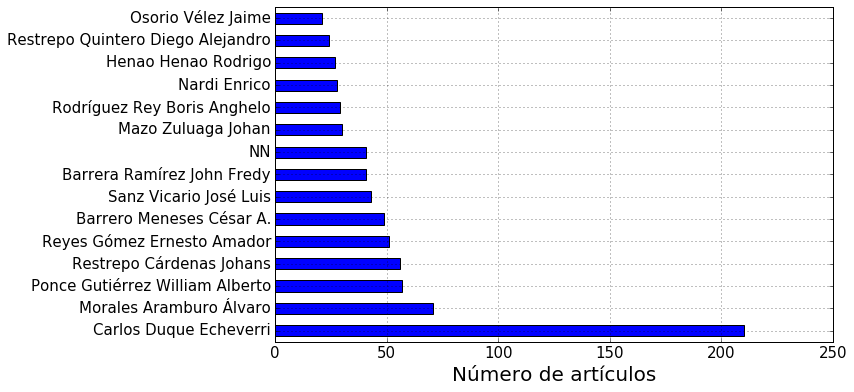

In [40]:
publicadas['First_UdeA_Author'].value_counts()[:15].plot(kind='barh', rot=0, grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos cinco años

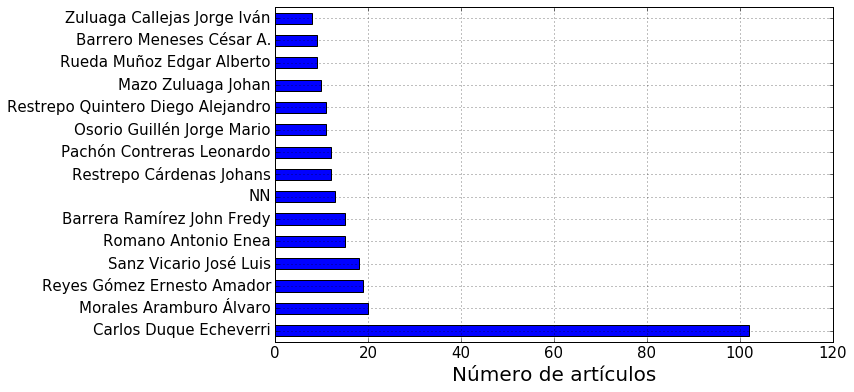

In [41]:
publicadas5['First_UdeA_Author'].value_counts()[:15].plot(kind='barh', rot=0, grid=True)#
plt.xlabel(u'Número de artículos',size=20)

###Conclusión
Se alcanza a notar algo del relevo generacional

Ejemplos plots con `pandas`: http://pandas.pydata.org/pandas-docs/dev/visualization.html

### Internacionales y Nacionales

The group counts, analogous to the value_counts function above, can be computed
    using size. This result is then reshaped into a table with unstack:

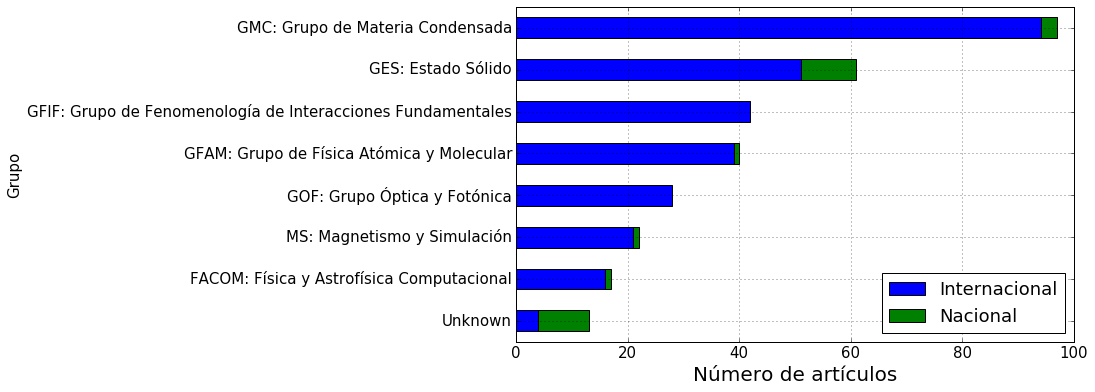

In [42]:
tipo5 = np.where(publicadas5['Tipo'].str.contains('Internacional'),'Internacional', 'Nacional')
by_group_tipo5 = publicadas5.groupby(['Grupo', tipo5])
gt_counts = by_group_tipo5.size().unstack().fillna(0)
indexer = gt_counts.sum(1).argsort()
count_subset = gt_counts.take(indexer)
count_subset[4:].plot(kind='barh', stacked=True,grid=True)
plt.xlabel(u'Número de artículos',size=20)

## Resultados por citaciones a los artículos

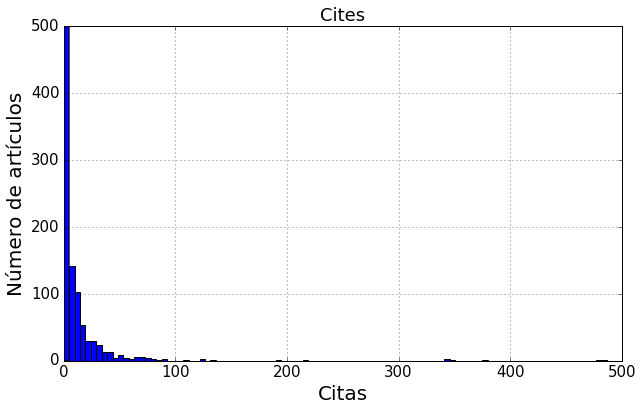

In [43]:
publicadas[['Cites']].hist(bins=100)
#plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Citas',size=20)
plt.ylabel(u'Número de artículos',size=20)

(0, 100)

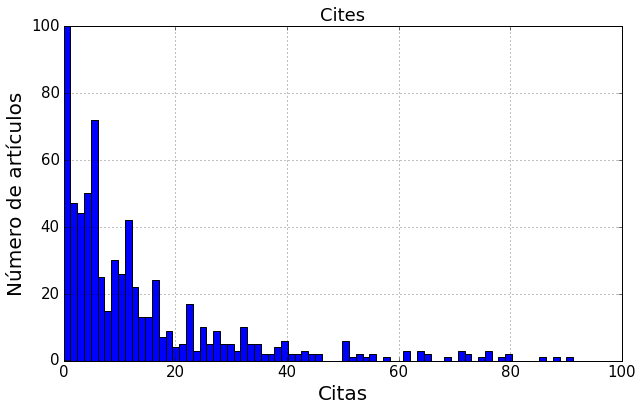

In [44]:
publicadas[['Cites']].hist(bins=400)
#plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Citas',size=20)
plt.ylabel(u'Número de artículos',size=20)
plt.xlim(0,100)
plt.ylim(0,100)

Incluye el índice h [https://en.wikipedia.org/wiki/H-index]

#### Global

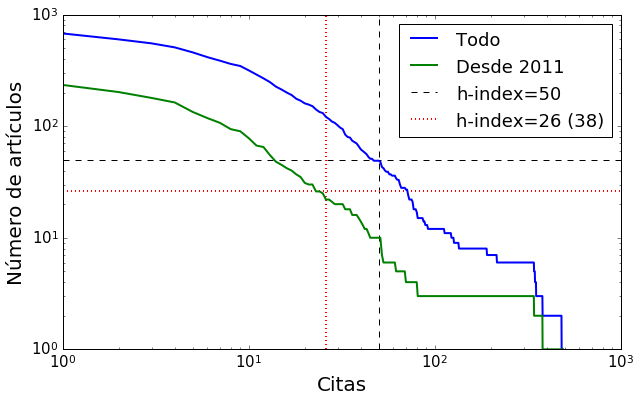

In [45]:
def h_index(x,y):
    ax=np.asarray(x)
    ay=np.asarray(y)
    return ax[ax>ay][0]

x=range(1,publicadas.Cites.max()+1,1)
y=[publicadas[publicadas.Cites>=c].shape[0] for c in x]
h=h_index(x,y)
plt.hlines(h,1,1000,linestyles='dashed',label='h-index=%d' %h)
plt.vlines(h,1,1000,linestyles='dashed')
plt.loglog(x,y,lw=2,label='Todo')
x=range(1,publicadas5.Cites.max()+1,1)
y=[publicadas5[publicadas5.Cites>=c].shape[0] for c in x]
h=h_index(x,y)
plt.hlines(h,1,1000,linestyles='dotted',lw=2,colors='r',label='h-index=%d (38)' %h)
plt.vlines(h,1,1000,linestyles='dotted',lw=2,colors='r')
plt.loglog(x,y,lw=2,label='Desde 2011')
plt.legend(loc='best')
plt.xlabel('Citas',size=20)
plt.ylabel(u'Número de artículos',size=20)

La diferencia con los últimos cinco años puede ser atribuible a los artículos con muchos autores

#### Por Grupos histórico

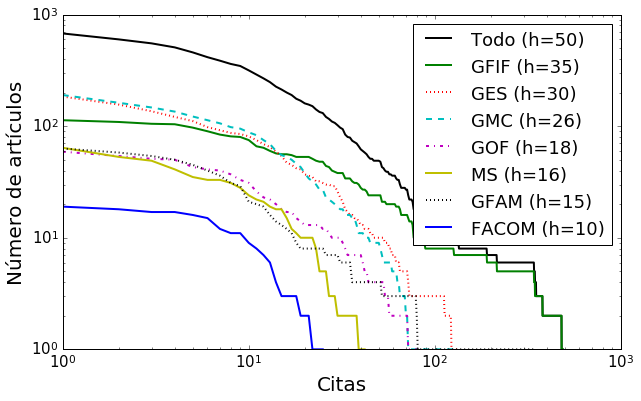

In [46]:
x=range(1,publicadas.Cites.max()+1,1)
y=[publicadas[publicadas.Cites>=c].shape[0] for c in x]
plt.loglog(x,y,'k-',lw=2,label='Todo (h=%d)' %h_index(x,y))

for G in ['GFIF','GES','GMC','GOF','MS','GFAM','FACOM']:
    pg=publicadas[publicadas.Grupo.str.contains(G)]
    x=range(1,pg.Cites.max()+1,1)
    y=[pg[pg.Cites>=c].shape[0] for c in x]

    plt.loglog(x,y,s[G],lw=2,label='%s (h=%d)' %(G,h_index(x,y)))
    
plt.legend(loc='best')
plt.xlabel('Citas',size=20)
plt.ylabel(u'Número de artículos',size=20)

#### Por Grupos últimos 5 años

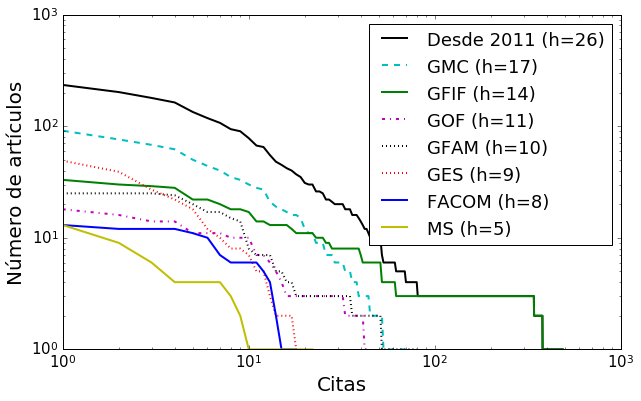

In [47]:
x=range(1,publicadas5.Cites.max()+1,1)
y=[publicadas5[publicadas5.Cites>=c].shape[0] for c in x]
plt.loglog(x,y,'k-',lw=2,label='Desde 2011 (h=%d)' %h_index(x,y))

for G in ['GMC','GFIF','GOF','GFAM','GES','FACOM','MS']:
    pg=publicadas5[publicadas5.Grupo.str.contains(G)]
    x=range(1,pg.Cites.max()+1,1)
    y=[pg[pg.Cites>=c].shape[0] for c in x]

    plt.loglog(x,y,s[G],lw=2,label='%s (h=%d)' %(G,h_index(x,y)))
    
plt.legend(loc='best')
plt.xlabel('Citas',size=20)
plt.ylabel(u'Número de artículos',size=20)

GFIF: Tres artículos en CMS que en realidad son 10 (h-> 24)

### Conclusión:
Sabemos hacer el menú del día, pero...

_¿Como hacer un plato gourmet?_

## Restados sobre índicadores asociados a las revistas

### Clasificación Colciencias

In [48]:
total=publicadas['Clasificación Colciencias'].value_counts()
print "Total A1+A2: ",total['A1']+total['A2']

Total A1+A2:  730


#### Histórico

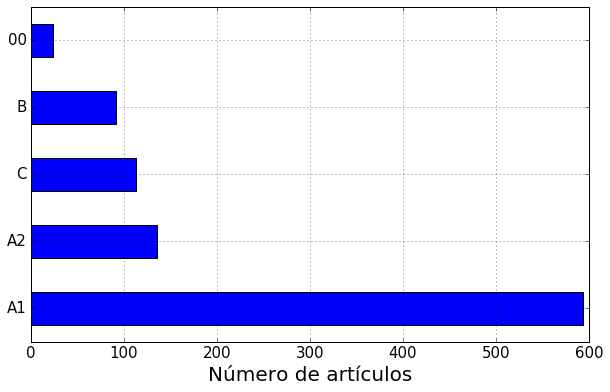

In [49]:
publicadas['Clasificación Colciencias'].value_counts().plot(kind='barh',grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos cinco  años

In [50]:
total=publicadas5['Clasificación Colciencias'].value_counts()
print "Total A1+A2: ",total['A1']+total['A2']

Total A1+A2:  291


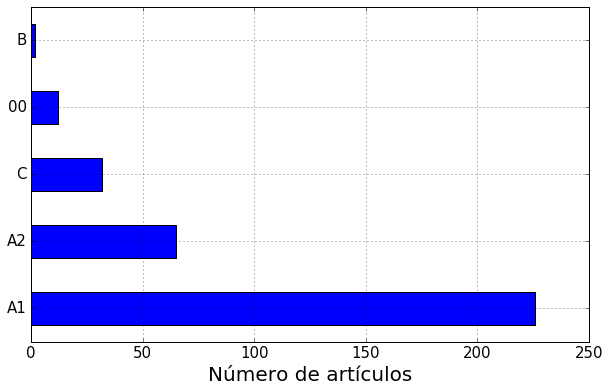

In [51]:
publicadas5['Clasificación Colciencias'].value_counts().plot(kind='barh',grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Publicadas último año

In [52]:
import datetime
publicadas1=publicadas[publicadas['Año']>datetime.datetime.now().year-1]
len(publicadas1)

4

<h2 id="FI">Factor de impacto</h2>
### Factor de impacto (FI) en revistas con FI>0
Factor de impacto de los últimos 4 años. Para publicaciones muy antigüas se usa el FI más antigüo

#### Histórico

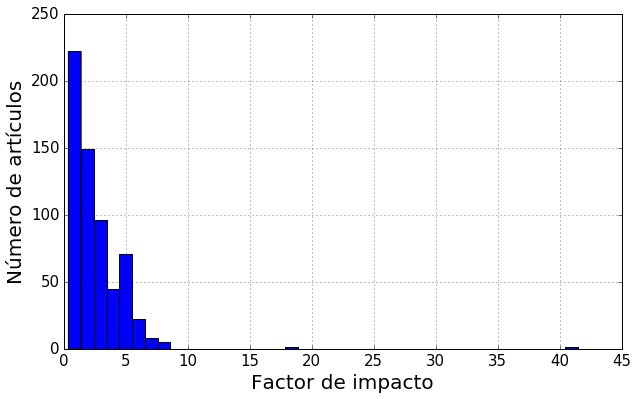

In [53]:
fi=publicadas[['Factor de Impacto']].replace('null',0)
fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
fii.astype('float')['Factor de Impacto'].hist(bins=40)
plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Factor de impacto',size=20)

Impondremos un corte para facilitar la visualización: FI<15

In [54]:
publicadas=publicadas[publicadas['Factor de Impacto']<15]

#### Histórico por Grupos

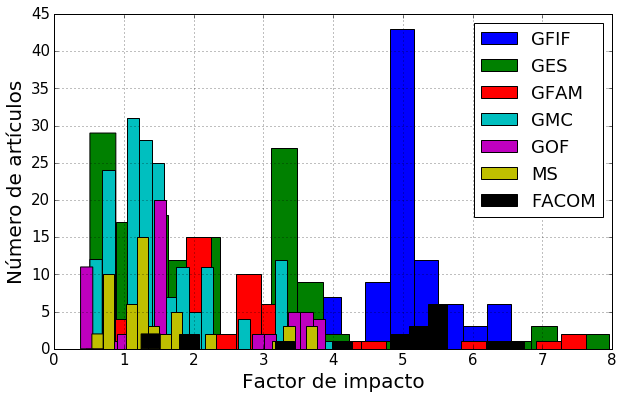

In [55]:
for group in ['GFIF','GES','GFAM','GMC','GOF','MS','FACOM']:
    fi=publicadas[publicadas['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=20,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

#### Últimos cinco años Global

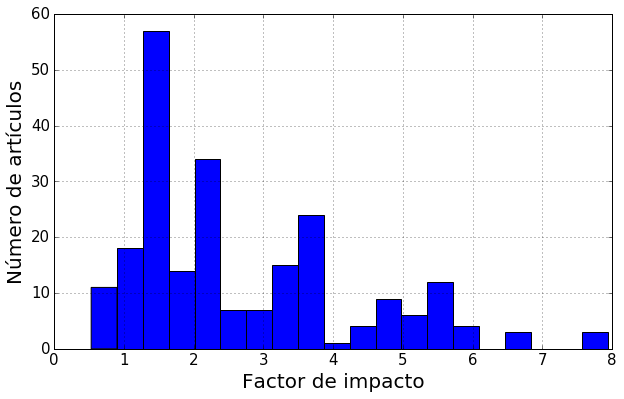

In [56]:
publicadas5['Factor de Impacto']=publicadas5['Factor de Impacto'].replace('Desconocido',-1)
fi=publicadas5[['Factor de Impacto']].replace('null',0)
fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
fii.astype('float')['Factor de Impacto'].hist(bins=20)
plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Factor de impacto',size=20)

#### Últimos cinco años: por Grupos

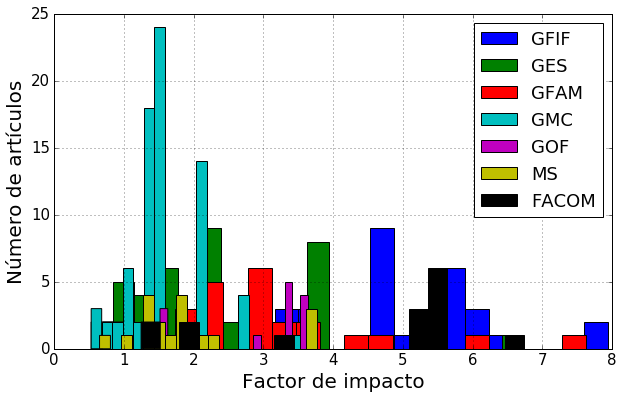

In [57]:
for group in ['GFIF','GES','GFAM','GMC','GOF','MS','FACOM']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=20,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

Detalles

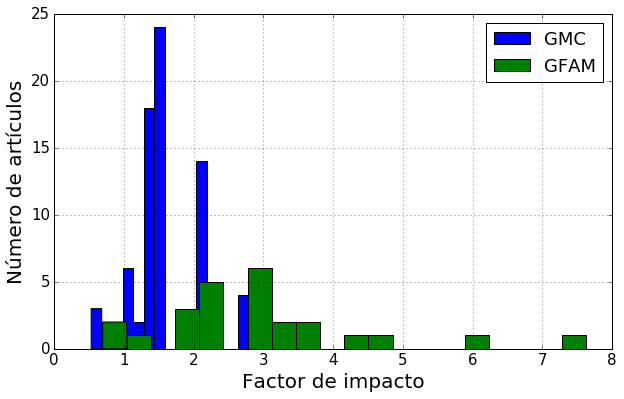

In [58]:
for group in ['GMC','GFAM']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=20,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

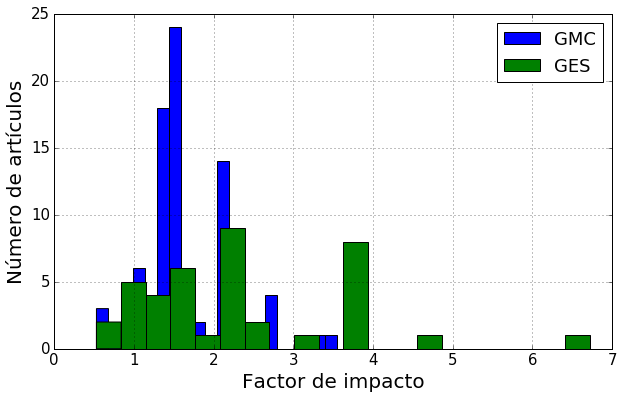

In [59]:
for group in ['GMC','GES']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=20,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

## Y patentes:
2

## Conlusiones generales

* Una estrategía mínima para mantener la media de publicaciones del los grupos, es garantizar el relevo de sus miembros _activos_.

* El número promedio de artículos por año para un teórico _activo_ es de 4 artículos (en el caso conservador), y para un experimental _activo_ es de 1. La contratación de N teóricos podría implicar un incrementeo de 4N artículos por año pasando de 6(ISI-Scopus). 

* Los 3 artículos de CMS se notan en los gráficos de citaciones. CMS y ATLAS están produciendo 100 artículos por año con 10,000 citaciones.  La grandes colaboraciones impactan fuertemente en cantidad y calidad de artículos. 

* En general. El incremento en el impacto de las publicaciones requiere cambios de paradigma.

* La grades colaboraciones impactan en número e impacto

* Congresos bien establecidos pueden crear incentivos de publicación en estudiantes

In [60]:
#0120-2650 revista colombiana de Fisica
#Physical Review D -> Jose David
#10.1038/nature09084
publicadas[publicadas['Grupo']=='Unknown'].sort('Year').shape

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(41, 35)

In [61]:
df[np.logical_and(df.DOI=='Not DOI',df.ISSN=='0000-0000')].shape

(49, 33)

In [62]:
df[np.logical_and(df.Authors.str.contains('Ponce'),df.Year==2015)]

,Year,Type,Authors,Publication,Volume,Pages,ISSN,Title,Impreso,PDF,Group,DOI,Type II,Proyect ID,Institution Authors,Colciencias Clasification,Impact Factor,Proyecto,NPages,Año,Tipo,Autor(es),Artículo,Vol.,pág.,Revista,Grupo,Clasificación Colciencias,Factor de Impacto,First_UdeA_Author,Area,Cites,Simple
977,2015,Internacional,"Benavides, Richard H; Ponce, William A;",Nuclear and Particle Physics Proceedings,267,370,0920-5632,The assignment of Lepton number and neutrino masses in 3-3-1 models,NaN,NaN,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,10.1016/j.nuclphysbps.2015.11.002,NaN,NaN,Ponce Gutiérrez William Alberto,A2,"-1,0",NaN,6,2015,Internacional,"Benavides, Richard H; Ponce, William A;",The assignment of Lepton number and neutrino masses in 3-3-1 models,267,370,Nuclear and Particle Physics Proceedings,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,A2,"-1,0",Ponce Gutiérrez William Alberto,Teórica,0,theassignmentofleptonnumberandneutrinomassesin331models
1005,2015,Internacional,"Salazar, Camilo; Benavides, Richard H; Ponce, William A; Rojas, Eduardo;",Journal of High Energy Physics,2015,1,1126-6708,LHC constraints on 3-3-1 models,NaN,NaN,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,10.1007/JHEP07(2015)096,NaN,NaN,Ponce Gutiérrez William Alberto,A1,"5,618",NaN,19,2015,Internacional,"Salazar, Camilo; Benavides, Richard H; Ponce, William A; Rojas, Eduardo;",LHC constraints on 3-3-1 models,2015,1,Journal of High Energy Physics,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,A1,"5,618",Ponce Gutiérrez William Alberto,Teórica,4,lhcconstraintson331models
1006,2015,Internacional,"Benavides, Richard H; Epele, Luis N; Fanchiotti, Huner; García Canal, Carlos; Ponce, William A;",Advances in High Energy Physics,2015,1,1687-7357,Lepton number violation and neutrino masses in 3-3-1 models,NaN,NaN,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,10.1155/2015/813129,NaN,NaN,Ponce Gutiérrez William Alberto,A2,"2,203",NaN,9,2015,Internacional,"Benavides, Richard H; Epele, Luis N; Fanchiotti, Huner; García Canal, Carlos; Ponce, William A;",Lepton number violation and neutrino masses in 3-3-1 models,2015,1,Advances in High Energy Physics,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,A2,"2,203",Ponce Gutiérrez William Alberto,Teórica,0,leptonnumberviolationandneutrinomassesin331models


In [70]:
a='CMS, collaboration'

In [72]:
a.split(';')[0].split(',')

['CMS', ' collaboration']